# npr MC1: Cleantech Retrieval Augemented Generation

**Dominik Filliger, Nils Fahrni, Noah Leuenberger**

> The topic of Mini-Challenge 1 is retrieval augmented generation (RAG) incorporating a combination of unsupervised learning, pre-training and in-context learning techniques.

- [Description of the task](https://spaces.technik.fhnw.ch/storage/uploads/spaces/81/exercises/NPR-Mini-Challenge-1-Cleantech-RAG-1708982891.pdf)
- [Introduction to RAG](https://spaces.technik.fhnw.ch/storage/uploads/spaces/81/exercises/Retrieval-Augmented-Generation-Intro-1709021241.pdf)


# Structure of our Solution

This notebook serves as the main entry point for our solution to the NPR Mini-Challenge 1. We will provide a detailed explanation of our approach and the code we used to solve the task. However, we have outsourced the code for the evaluation, Langchain LLM model creation and vectorstore interaction to script files which can be found in the `src` directory. We will reference these scripts in the respective sections and explain the code in place.

Additionally, scripts for the development subset and subset evaluation set creation can be found in the `scripts` directory and will be referenced in their respective sections. These were primarily used to speed up the development process and are not necessary for the final solution as we will use the full dataset for the latest evaluation.

The notebook starts by setting up a baseline pipeline. After that, we will conduct a series of experiments to explore the impact of different strategies on the performance of the pipeline. The experiments are designed to test the effectiveness of different retrieval and generation strategies in the RAG pipeline.



# Setup

The setup section is used to import the necessary libraries and set the configuration for the notebook. We will also load the environment variables from the `.env` file to set the configuration for the notebook. The configuration includes the paths to the data files and the configuration for the Phoenix library.

There is an option of three boolean variables which can be set to `True` or `False` to configure the notebook:
- `DEV_MODE`: If set to `True`, the notebook will use the development subset of the data. If set to `False`, the notebook will use the full dataset.
- `USE_GPU`: If set to `True`, the notebook will use the GPU for the computations. If set to `False`, the notebook will use the CPU.
- `USE_CACHE`: If set to `True`, the notebook will use the cache for the computations. If set to `False`, the notebook will not use the cache.

The caching is especially useful when running the notebook multiple times to avoid recomputing the same results. Especially the evaluation of the pipelines can be time-consuming and require a lot of tokens from the Azure API. Therefore, it is recommended to set `USE_CACHE` to `True` when running the notebook multiple times.

In [1]:
import os

from dotenv import load_dotenv

load_dotenv()

DEV_MODE = False
USE_GPU = False
USE_CACHE = True

## Pathing

The pathing section is used to set the paths to the data files. The paths are set based on the `DEV_MODE` variable. If `DEV_MODE` is set to `True`, the paths to the development subset of the data are used. If `DEV_MODE` is set to `False`, the paths to the full dataset are used. The paths are then used to load the data files into pandas DataFrames. This is sole for convenience and to have a clear separation of the paths in one place.

In [2]:
def get_path(dev_mode=DEV_MODE):
    if dev_mode:
        # Paths used in development mode
        return {
            'df_path': 'data/subset/cleantech_media_dataset_v2_2024-02-23_subset.csv',
            'df_eval_path': 'data/subset/cleantech_media_dataset_v2_2024-02-23_subset_eval.csv',
            'df_preprocessed_path': get_preprocessed_path(
                'data/subset/cleantech_media_dataset_v2_2024-02-23_subset.csv'),
            'df_eval_preprocessed_path': get_preprocessed_path(
                'data/subset/cleantech_media_dataset_v2_2024-02-23_subset_eval.csv')
        }
    else:
        # Paths used in production mode
        return {
            'df_path': 'data/Cleantech Media Dataset/cleantech_media_dataset_v2_2024-02-23.csv',
            'df_eval_path': 'data/Cleantech Media Dataset/cleantech_rag_evaluation_data_2024-02-23.csv',
            'df_preprocessed_path': get_preprocessed_path(
                'data/Cleantech Media Dataset/cleantech_media_dataset_v2_2024-02-23.csv'),
            'df_eval_preprocessed_path': get_preprocessed_path(
                'data/Cleantech Media Dataset/cleantech_rag_evaluation_data_2024-02-23.csv')
        }


def get_preprocessed_path(path: str) -> str:
    return path.replace(".csv", "_preprocessed.csv")


paths = get_path()
print(paths)

{'df_path': 'data/Cleantech Media Dataset/cleantech_media_dataset_v2_2024-02-23.csv', 'df_eval_path': 'data/Cleantech Media Dataset/cleantech_rag_evaluation_data_2024-02-23.csv', 'df_preprocessed_path': 'data/Cleantech Media Dataset/cleantech_media_dataset_v2_2024-02-23_preprocessed.csv', 'df_eval_preprocessed_path': 'data/Cleantech Media Dataset/cleantech_rag_evaluation_data_2024-02-23_preprocessed.csv'}


## Observability & Monitoring

> Phoenix is an open-source observability library designed for experimentation, evaluation, and troubleshooting. It allows AI Engineers and Data Scientists to quickly visualize their data, evaluate performance, track down issues, and export data to improve.

We will use Phoenix to visualize traces to quickly debug pipelines. The library offers way more feature which we will not use. Down below we add the Phoenix callbacks to Langchain, our main library for the solution, to visualize the traces.

To get quick access to the Phoenix dashboard, open the following link in your browser: [http://localhost:6006](http://localhost:6006)


In [3]:
from phoenix.trace.langchain import LangChainInstrumentor
import phoenix as px

try:
    px.close_app()
    session = px.launch_app()
except:
    print(
        "Could not launch Phoenix app. Please make sure any existing Phoenix app process is closed. Restart the kernel if necessary.")

LangChainInstrumentor().instrument()

No active session to close
🌍 To view the Phoenix app in your browser, visit http://localhost:6006/
📺 To view the Phoenix app in a notebook, run `px.active_session().view()`
📖 For more information on how to use Phoenix, check out https://docs.arize.com/phoenix


# Data Loading & Preprocessing

Next we will load the data and preprocess it. The data is loaded into a pandas DataFrame and then preprocessed. This step is based on the findings and explorations made in the EDA notebook (`notebooks/exploration.ipynb`). 

The dataset used in this Mini-Challenge is the Cleantech Media Dataset, which contains articles about clean technology and sustainability topics. The dataset consists of various columns, including the URL, domain, title, author, date, and content of the articles. The content column is of main interest as it contains the text data which the RAG piepline will be built upon. The dataset can be found [on Kaggle](https://www.kaggle.com/datasets/jannalipenkova/cleantech-media-dataset) together with an evaluation set which will be discussed later in the notebook.

The preprocessing code itself can be found in the `src/preprocessing.py` file. The code is encapsulated in a class called `Preprocessor` which is used to preprocess the data which will be indexed and used for the retrieval augmented generation pipeline. There is also a separate class called `EvaluationPreprocessor` which is used to preprocess the evaluation set which will be discussed later in the notebook.

The preprocessing includes the following steps:

1. **Language Detection and Filtering:** Detect the language of each text chunk and filter out non-English chunks to maintain language consistency in the dataset.
2. **HTML Cleaning:** Remove any HTML tags from the text content to ensure that only relevant textual data is processed.
3. **Removing Special Characters:** Clean up the text by removing non-alphanumeric characters, keeping only letters, numbers, and necessary punctuation.
4. **Duplicate Removal:** Identify and remove duplicate text chunks based on content to ensure uniqueness in the dataset.
5. **Content Concatenation:** If the text content is split across multiple entries or rows, concatenate these into a single text chunk per dataset entry.
6. **Adding Unique Identifiers:** Generate and append a unique identifier to each row based on the content's hash value, which helps in tracking and indexing the data for the evaluation process of the retrieval.

In [4]:
import pandas as pd

df = pd.read_csv(get_path()['df_path'])
df.head()

,Unnamed: 0,title,date,author,content,domain,url
0,1280,Qatar to Slash Emissions as LNG Expansion Adva...,2021-01-13,NaN,"[""Qatar Petroleum ( QP) is targeting aggressiv...",energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...
1,1281,India Launches Its First 700 MW PHWR,2021-01-15,NaN,"[""• Nuclear Power Corp. of India Ltd. ( NPCIL)...",energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...
2,1283,New Chapter for US-China Energy Trade,2021-01-20,NaN,"[""New US President Joe Biden took office this ...",energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...
3,1284,Japan: Slow Restarts Cast Doubt on 2030 Energy...,2021-01-22,NaN,"[""The slow pace of Japanese reactor restarts c...",energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...
4,1285,NYC Pension Funds to Divest Fossil Fuel Shares,2021-01-25,NaN,"[""Two of New York City's largest pension funds...",energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...


The preprocessed data is then saved to a new CSV file to avoid recomputing the preprocessing steps when running the notebook multiple times.

In [5]:
from src.preprocessing import Preprocessor

if os.path.exists(paths['df_preprocessed_path']) and USE_CACHE:
    df = pd.read_csv(paths['df_preprocessed_path'])
else:
    df = Preprocessor(df).preprocess()
    df.to_csv(paths['df_preprocessed_path'], index=False)

# Indexing

The indexing step is used to embed the documents and store them in a vector store. The vector store is used to store the embeddings and provide an interface to interact with the embeddings.

## Chunking

Another important step in the indexing process is to split the documents into smaller chunks. This division is crucial for managing large documents, improving the granularity of search results, and enhancing the efficiency of the embedding process.

**Purpose and Benefits**:

- **Manageability**: Smaller chunks are easier to process and store, reducing the computational burden on the system.
- **Precision**: By embedding smaller sections of text, the system can achieve more precise document retrieval, particularly for queries that target specific information within a large document.
- **Performance**: Smaller text chunks lead to faster processing times during both embedding and retrieval phases.

For the baseline pipeline, we will use the Recursive Character Text Splitter from the Langchain library. This splitter divides the text into smaller chunks based on the character count, ensuring that each chunk is of a manageable size for processing and embedding. The following parameters are used for the splitter:

- **Chunk Size**: The maximum number of characters in each chunk.
    - We use a chunk size of 1000 characters to ensure that the chunks are small enough for efficient processing but large enough to capture meaningful information. 
- **Chunk Overlap**: The number of characters that overlap between adjacent chunks.
    - We set the overlap to 0 to avoid redundancy and ensure that each chunk contains unique information.   
- **Length Function**: The function used to calculate the length of the text.
- **Is Separator Regex**: A flag indicating whether the separator is a regular expression.

The recursive character text splitter is a simple and effective method for dividing text into manageable chunks, making it suitable for our initial experiments with the RAG pipeline. 

In [6]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

recursive_text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=0,
    length_function=len,
    is_separator_regex=False,
)

The helper function `create_documents` is used to create the documents from the DataFrame. The function takes the DataFrame and the text splitter as input and returns the documents. The function also prints the number of documents created and the percentage of documents created compared to the number of rows in the source DataFrame.

In [7]:
def create_documents(df: pd.DataFrame, text_splitter, verbose=True):
    metadata_cols = ['url', 'domain', 'title', 'author', 'date', 'id']
    if not all(col in df.columns for col in metadata_cols + ['content']):
        raise ValueError(
            f"DataFrame must contain all metadata columns and a 'content' column: {metadata_cols + ['content']}")

    metadata = df[metadata_cols].rename(columns={'id': 'origin_doc_id'}).to_dict('records')
    for i, m in enumerate(metadata):
        metadata[i] = {k: 'None' if v is None else v for k, v in m.items()}

    docs = text_splitter.create_documents(df['content'], metadata)

    if verbose:
        print(
            f"{text_splitter.__class__.__name__}: "
            f"Number of documents created: {len(docs)}, "
            f"Number of rows in source df: {len(df)}, "
            f"Percentage of documents created: {len(docs) / len(df) * 100:.2f}%")

    return docs


documents = create_documents(df, recursive_text_splitter)

RecursiveCharacterTextSplitter: Number of documents created: 49939, Number of rows in source df: 9583, Percentage of documents created: 521.12%


In [8]:
documents[0]

Document(page_content='Qatar Petroleum  QP is targeting aggressive cuts in its greenhouse gas emissions as it prepares to launch Phase 2 of its planned 48 million ton per year LNG expansion In its latest Sustainability Report published on Wednesday QP said its goals include  reducing the emissions intensity of Qatars LNG facilities by 25 and of its upstream facilities by at least 15  The company is also aiming to reduce gas flaring intensity across its upstream facilities by more than 75 and has raised its carbon capture and storage ambitions from 5 million tonsyr to 7 million tonsyr by 2027 About 22 million tonsyr of the carbon capture goal will come from the 32 million tonyr Phase 1 of the LNG expansion also known as the North Field East project A further 11 million tonsyr will come from Phase 2 known as the North Field South project which will raise Qatars LNG capacity by a further 16 million tonsyr Qatar currently has an LNG production capacity of around 78 million tonsyr and is ey

Once split, each text chunk is processed through the BGE embeddings model to generate individual vectors. These vectors are then stored in the vector store. Handling multiple embeddings per document involves indexing each chunk separately while maintaining a reference to the original document.

## Embeddings

We will use the [BGE embeddings from Hugging Face](https://huggingface.co/BAAI/bge-small-en) to embed the documents. BGE embeddings are transformer-based models trained on a vast corpus of text data, making them highly effective for a variety of NLP tasks. The embeddings convert text data into dense vectors of fixed dimensionality, typically via processes including tokenization and normalization. The resulting vectors capture the semantic properties of the input texts.

**Why specifically BGE embeddings?**

- **High Semantic Fidelity**: BGE embeddings are designed to capture deep semantic meanings, enabling more effective document similarity checks and retrieval.
- **Performance**: They are optimized for both accuracy and speed in large-scale applications.
- **Versatility**: Suitable for diverse NLP tasks such as classification, clustering, and information retrieval.
- **Accessibility through Langchain**: The Langchain library provides a simple interface to interact with the BGE embeddings, making it easier to integrate them into the RAG pipeline.

In [9]:
from langchain_community.embeddings.huggingface import HuggingFaceBgeEmbeddings

bge_embeddings = HuggingFaceBgeEmbeddings(
    model_name="BAAI/bge-small-en",
    model_kwargs={"device": "cpu" if not USE_GPU else "cuda:0"},
    encode_kwargs={"normalize_embeddings": True}
)

## Vector Store

We will use [ChromaDB](https://www.trychroma.com/) to store the embeddings. For easier interaction with the embeddings, we will use the `VectorStore` class which can be found in the `src/vector_store.py` file. The `VectorStore` class provides an interface that combines a specific collection of embeddings with the Langchain VectorStore API. The class allows for easy interaction with the embeddings, including adding documents and performing similarity searches.

The embedding of the chunks takes time and resources, so we will use a persistent store to save the embeddings and avoid recomputing them when running the notebook multiple times. A database file with the precomputed embeddings can be downloaded and integrated according to the instructions in the README file.

The collection name for the vector store is generated based on the embeddings model and the text splitter used. The collection name is used to identify the specific collection of embeddings in the vector store.

In [10]:
from src.vector_store import VectorStore


def get_vector_store_collection_name(embeddings, text_splitter):
    return f"cleantech-{embeddings.model_name}-{text_splitter.__class__.__name__}_{'dev' if DEV_MODE else 'prod'}".lower().replace(
        " ", "_").replace("/", "_").replace(":", "_").replace("-", "_")


bge_vector_store = VectorStore(embedding_function=bge_embeddings,
                               collection=get_vector_store_collection_name(bge_embeddings, recursive_text_splitter))

get_vector_store_collection_name(bge_embeddings, recursive_text_splitter)

'cleantech_baai_bge_small_en_recursivecharactertextsplitter_prod'

In the next step we will add the prepared documents from the previous step to the VectorStore. If the collection already exists in the VectorStore, this step is skipped.

In [11]:
bge_vector_store.add_documents(documents, verbose=True)

Collection cleantech_baai_bge_small_en_recursivecharactertextsplitter_prod already exists in the vector store.


After adding the documents to the vector store we can now perform similarity searches on the documents to verify that the interaction with the vector store works as expected.

In [12]:
bge_vector_store.similarity_search_w_scores("The company is also aiming to reduce gas flaring?")

[(Document(page_content='lowercarbon solution we are investing in that will position our customers to reduce the carbon intensity of their businesses and everyday lives We ve also invested in developing and supplying renewable natural gas blending renewables into our fuels coprocessing biofeedstocks in our refineries and abatement projects that will reduce the carbon intensity of our operations  Among its other hydrogenrelated projects Chevron and Toyota Motor Corp in April agreed to join forces to develop  viable  and  largescale businesses  to capitalize on the ascension of hydrogen as a clean source of fuel The three other initiatives being explored by Chevron and Cummins include analyzing market demand for commercial vehicles and industrial applications powered by hydrogen In addition plans are to look at ways to develop infrastructure to support the use of hydrogen for industry and fuel cell vehicles Finally the companies would explore opportunities to leverage Cummins electrolyze

The vector store returns a list of documents with their respective similarity scores. The documents are sorted by their similarity scores in descending order. The similarity scores indicate how similar the documents are to the query text. The higher the similarity score, the more similar the document is to the query text.

# Baseline Pipeline

The baseline pipeline is a first simple implementation of the RAG pipeline. As the name suggests, it serves as the starting point for our experiments and provides a reference for comparison with the subsequent pipelines. The baseline pipeline consists of the following components:

- **Embeddings**: We use the BGE embeddings from Hugging Face to embed the documents.
- **Retriever**: In the baseline pipeline, we use the default vector retriever from ChromaDB. It returns the top-4 most similar documents based on the cosine similarity.
- **LLM Model**: We use the GPT-3.5 model provided on Azure as our LLM model. The model is responsible for generating the answer to the question based on the retrieved documents. The temperature parameter is set to the default of 0.7. 

In [13]:
from src.generation import get_llm_model, LLMModel
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.runnables import RunnableParallel

base_retriever = bge_vector_store.get_retriever()
azure_model = get_llm_model(LLMModel.GPT_3_AZURE)

We will use the following prompt template to generate the chat prompt for the LLM model. The template includes the context and the question to provide the necessary information for the model to generate the answer and is fairly simple.

In [14]:
base_rag_prompt = """
Answer the question to your best knowledge when looking at the following context:
{context}
                
Question: {question}
"""

The `base_rag_chain` is the core of the baseline pipeline. It consists of the following steps:

1. **Context Formatting**: The context documents are formatted into a single string to provide the necessary information to the LLM model.
2. **Chat Prompt Generation**: The chat prompt is generated using the template defined above.
3. **LLM Model Invocation**: The LLM model is invoked to generate the answer based on the context and the question.
4. **Output Parsing**: The output from the LLM model is parsed to extract the answer from the response.
5. **Answer Assignment**: The answer is assigned to the runnable parallel chain where it is combined with the context and the question. Context and question are also returned for further reference in the evaluation.

In [15]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


base_rag_chain = (
        RunnablePassthrough.assign(context=(lambda x: format_docs(x["context"])))
        | ChatPromptTemplate.from_template(base_rag_prompt)
        | azure_model
        | StrOutputParser()
)

base_rag = RunnableParallel(
    {
        "context": base_retriever,
        "question": RunnablePassthrough()
    }
).assign(answer=base_rag_chain)

The `base_rag` pipeline/chain can now be used to generate answers for questions. We will test the pipeline with a sample question to verify that it works as expected.

In [16]:
base_rag.invoke("Is the company aiming to reduce gas flaring?")

{'context': [Document(page_content='with carbon capture and storage or other emerging technologies  the firm said  ExxonMobil plans to expand its methane detection programs utilizing satellite surveillance and a network of groundbased sensors for continuous monitoring and aerial flyovers that identify leaks for rapid repairs  By the end of this year ExxonMobil plans to reduce flaring volumes across its Permian operations by more than 75 versus 2019 and to eliminate all routine flaring in the basin by the end of 2022  The company is also securing alternative natural gas delivery points across the basin to minimize nonroutine flaring  management said The net zero goal for Scope 1 and 2 emissions  is one of the most ambitious and widereaching in the Permian Basin  said ExxonMobil s Bart Cahir senior vice president of unconventional  Throughout the value chain our people are working hard to help reduce the greenhouse gas emissions associated with the products that enable modern life  Accor

# Evaluation Setup

In order to compare the performance of different pipelines we need to evaluate them. The evaluation is done with the `ragas` library and classical non-LLM based metrics. 

`ragas` provides predefined metrics for the evaluation which are described in the [documentation](https://docs.ragas.io/en/stable/concepts/metrics/index.html). 

Further an overview of the metrics used in the evaluation is provided below:

## RAGAS Metrics

The `ragas` metrics are LLM-based evaluated metrics where the LLM is used to rate the generated answers and retrieved contexts against labeled ground truths. As LLM are known for their non-deterministic behavior, the metrics should be taken with a grain of salt. Nevertheless, they provide a relatively simple and straightforward way to evaluate the performance.

1. [**Answer Correctness**](https://docs.ragas.io/en/stable/concepts/metrics/answer_correctness.html): This metric assesses the accuracy of the generated answer compared to the ground truth. It combines semantic and factual similarities between the answer and ground truth, providing a score ranging from 0 to 1. A higher score indicates that the generated answer closely aligns with the ground truth, reflecting a more correct response.

2. [**Context Precision**](https://docs.ragas.io/en/stable/concepts/metrics/context_precision.html): This metric evaluates the relevance of the contexts retrieved by the RAG system in relation to the ground truth. It checks if the relevant items from the ground truth are ranked higher in the retrieved contexts. Scores range from 0 to 1, where higher values suggest better precision and relevance of the retrieved information.

3. [**Answer Relevancy**](https://docs.ragas.io/en/stable/concepts/metrics/answer_relevance.html): Focused on the pertinence of the generated answer to the question, this metric scores based on how complete and free from redundant information the answer is. Higher scores indicate more relevant answers. It uses the mean cosine similarity between the original question and artificial questions generated based on the answer.

4. [**Answer Semantic Similarity**](https://docs.ragas.io/en/stable/concepts/metrics/semantic_similarity.html): This metric evaluates the semantic resemblance between the generated answer and the ground truth. It uses a cross-encoder model to calculate semantic similarity, with scores between 0 and 1. Higher scores signify a better semantic alignment between the generated answer and the ground truth.

5. [**Context Entity Recall**](https://docs.ragas.io/en/stable/concepts/metrics/context_entities_recall.html): This metric measures the recall of entities in the retrieved contexts against those in the ground truths. It is particularly useful in scenarios where factual accuracy and entity coverage are crucial, such as in historical QA or tourism help desks. The score is calculated by comparing the number of entities that overlap between the ground truths and contexts with the total number of entities in the ground truths.

## Non-LLM Based Metrics

In addition to the RAGAS metrics, we will also use the following metrics to evaluate the performance of the pipelines. They provide further specific insights into the retrieval performance.

1. **Reciprocal Rank**: The reciprocal rank is a metric that evaluates the ranking of the correct answer in the list of retrieved answers. It is calculated as the reciprocal of the rank of the correct answer. A higher reciprocal rank indicates that the correct answer is ranked higher in the list of retrieved answers.
2. **Hit@K**: The Hit@K metric evaluates whether the correct answer is present in the top K retrieved answers. It is calculated as a binary value, where 1 indicates that the correct answer is present in the top K retrieved answers, and 0 indicates otherwise. A higher Hit@K value indicates that the correct answer is more likely to be found in the top K retrieved answers
.

## Evaluation Data

The evaluation data is part of the datasets provided by the Mini-Challenge task [from Kaggle](https://www.kaggle.com/datasets/jannalipenkova/cleantech-media-dataset). The data consists of questions and a relevant chunk for each question.

To evaluate the RAG system (and the following experiments) it is necessary to preprocess the evaluation dataset. For that purpose an `EvaluationPreprocessor` was built which ensures that the chunks of text extracted from a dataset during an evaluation are indeed the most relevant or closest matches to a known dataset. This is critical as we need to see if the RAG's outputs and evaluation's expected outputs (ground truth) match using the listed metrics. To calculate "similarity" or find matches the `EvaluationPreprocessor` calculates a similarity based on **fuzzy string matching**.

In [17]:
df_eval = pd.read_csv(paths['df_eval_path'])
df_eval.head()

,example_id,question_id,question,relevant_chunk,article_url
0,1,1,What is the innovation behind Leclanché's new ...,Leclanché said it has developed an environment...,https://www.sgvoice.net/strategy/technology/23...
1,2,2,What is the EU’s Green Deal Industrial Plan?,The Green Deal Industrial Plan is a bid by the...,https://www.sgvoice.net/policy/25396/eu-seeks-...
2,3,2,What is the EU’s Green Deal Industrial Plan?,The European counterpart to the US Inflation R...,https://www.pv-magazine.com/2023/02/02/europea...
3,4,3,What are the four focus areas of the EU's Gree...,The new plan is fundamentally focused on four ...,https://www.sgvoice.net/policy/25396/eu-seeks-...
4,5,4,When did the cooperation between GM and Honda ...,What caught our eye was a new hookup between G...,https://cleantechnica.com/2023/05/08/general-m...


In [18]:
from src.preprocessing import EvaluationPreprocessor

if os.path.exists(paths['df_eval_preprocessed_path']) and USE_CACHE:
    df_eval = pd.read_csv(paths['df_eval_preprocessed_path'])
else:
    df_eval = EvaluationPreprocessor(df, df_eval).preprocess()
    df_eval.to_csv(paths['df_eval_preprocessed_path'], index=False)

df_eval.head()

,example_id,question_id,question,ground_truth,article_url,best_match_score,best_match_id
0,1,1,What is the innovation behind Leclanché's new ...,Leclanché said it has developed an environment...,https://www.sgvoice.net/strategy/technology/23...,92,83822030
1,2,2,What is the EU’s Green Deal Industrial Plan?,The Green Deal Industrial Plan is a bid by the...,https://www.sgvoice.net/policy/25396/eu-seeks-...,100,24914307
2,3,2,What is the EU’s Green Deal Industrial Plan?,The European counterpart to the US Inflation R...,https://www.pv-magazine.com/2023/02/02/europea...,98,96404623
3,4,3,What are the four focus areas of the EU's Gree...,The new plan is fundamentally focused on four ...,https://www.sgvoice.net/policy/25396/eu-seeks-...,100,24914307
4,5,4,When did the cooperation between GM and Honda ...,What caught our eye was a new hookup between G...,https://cleantechnica.com/2023/05/08/general-m...,99,38122686


After then `EvaluationPreprocessor` calculates the matches it adds the best score to each evaluation sample. The `best_match_id` represents the Id of the chunk which yielded the `best_match_score`, so this chunk seems to be the best matching chunk, according to the fuzzy matching, and should therefore be the chunk containing the information to answer the question. 

### Plausibility Checks
To see if the Baseline RAG Pipeline delivers *plausible* answers based on **handpicked questions** from the evaluation set the following lines will invoke the `base_rag` chain and ask these questions.

In [19]:
HANDPICKED_QUESTIONS = [
    "Why does melting ice contribute to global warming?",
    "In 2021, what were the top 3 states in the US in terms of total solar power generating capacity?",
    "What is the EU’s Green Deal Industrial Plan?"
]


def ask_handpicked_questions(rag_chain, questions=HANDPICKED_QUESTIONS):
    answers = {question: rag_chain.invoke(question) for question in questions}

    for question, answer in answers.items():
        print(f"Question: {question}")
        print(f"Answer: {answer['answer']}")
        print("\n")

ask_handpicked_questions(base_rag)

Question: Why does melting ice contribute to global warming?
Answer: The context does not provide a clear answer to this question. However, it does mention that melting ice sheets contribute to rising sea levels, which can have repercussions for global warming. It also mentions that monitoring and predicting the melting of coastal glaciers could pave the way to better predictions about sea level rise, which is a consequence of melting ice.


Question: In 2021, what were the top 3 states in the US in terms of total solar power generating capacity?
Answer: The top 3 states in the US in terms of total solar power generating capacity in 2021 were California, Florida, and Texas.


Question: What is the EU’s Green Deal Industrial Plan?
Answer: The EU's Green Deal Industrial Plan is a strategy aimed at boosting investment and economic resilience in the bloc to tackle the challenges of the green transition. It seeks to make the EU's net-zero industry more competitive and accelerate its transit

The Plausibility Check shows that the base RAG system indeed yields answers that are not out of the ordinary.
**Note**: Through the LLM's non-deterministic nature it is possible that each run shows slightly different answers.

Loaded cached results from cache/Baseline_16844371965479781967.pkl


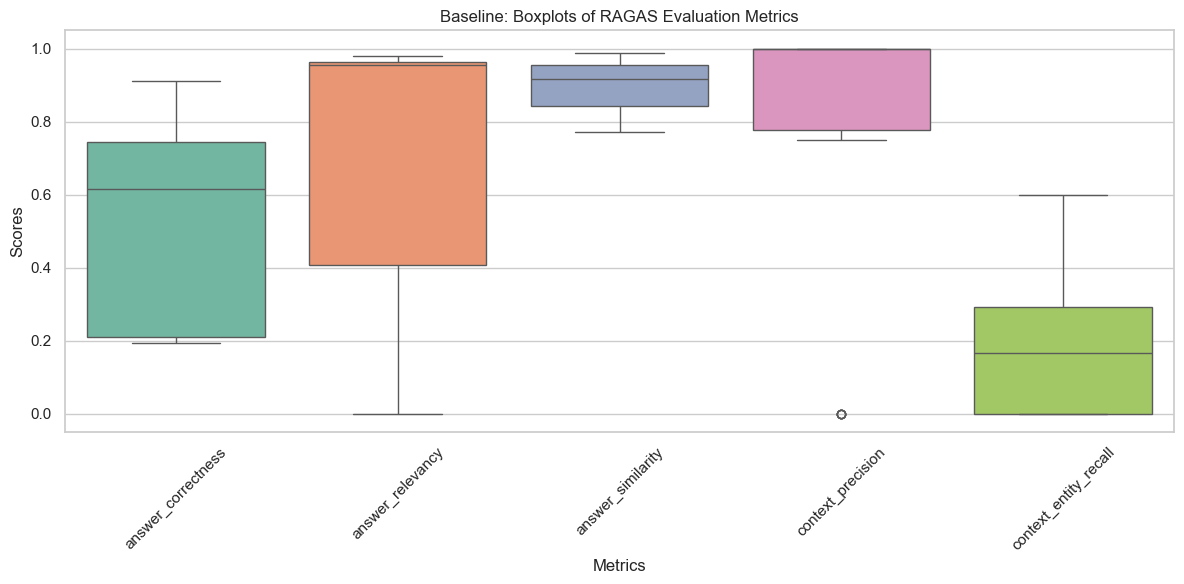

/Users/dmnk/PycharmProjects/npr-rag/src/evaluation.py:319: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=means.index, y=means, palette="Set2")


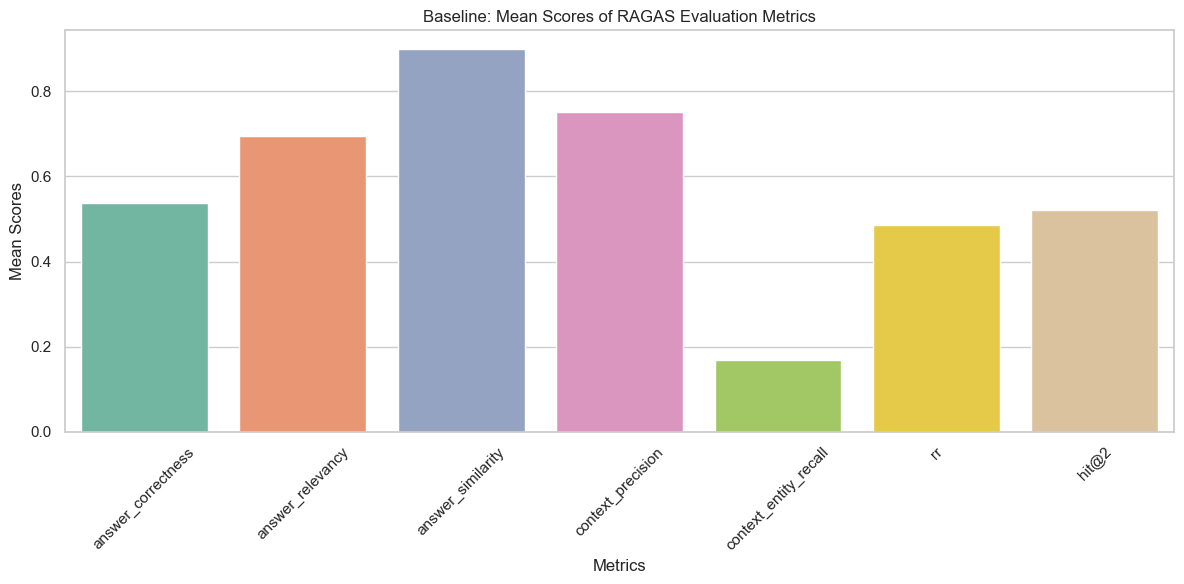

In [20]:
from src.evaluation import Evaluator

base_evaluator = Evaluator(name="Baseline",
                           cache_results=USE_CACHE,
                           rag_chain=base_rag,
                           llm_model=azure_model,
                           embeddings=bge_embeddings)

base_evaluator.evaluate(df_eval)
base_evaluator.plot_summary()

The results of the RAGAS metrics show quite large differences for the Baseline RAG pipeline. The largest spread can be observed for the metrics `answer_correctness` and `answer_relevancy`. The Baseline pipeline seems to score quite low in **Context Entity Recall** with over half of the evaluation results being below 30%. The more stable metrics of **Answer Similarity** and **Context Precision** show quite large scores, ranging from just under 80% up to 99% with one outlier.

The Baseline model seems to generally find the relevant chunks and seems to answer the questions semantically similar to the ground truths in the evaluation set. However, the low context entity recall indicates that the given answers don't exactly align well with the ground truths. We expect this to be a result of the LLM trying to come up with the correct answer without having the correct chunks of information at hand.

Additionally the Reciprocal Rank (`rr`) and Hit@2 don't exactly show satisfyingly high scores. They both settle at around 50% (mean) so the retrieved chunks seem to not be consistently retrieved correctly.

In [21]:
base_evaluator.get_summary()

,mean,std
answer_correctness,0.536966,0.265828
answer_relevancy,0.695409,0.424432
answer_similarity,0.898333,0.066898
context_precision,0.752415,0.411493
context_entity_recall,0.169358,0.163336
rr,0.485507,0.454809
hit@2,0.521739,0.510754


When looking at the magnitude of the standard deviation of both the reciprocal rank and the hit@2 we can get a sense of their wide distributions. This observation indicates that the documents are in fact not consistent and vary greatly in evaluation.

# Helper Functions
In order to make the notebook more readable and to avoid code duplication, we will define some helper functions that will be used throughout the notebook. These functions will help us to perform common tasks such as running experiments, evaluating pipelines, and visualizing the results.

In [68]:
def combine_evaluator_results(evaluators):
    """
    Combine evaluation results from multiple evaluators into a single DataFrame.

    Args:
    evaluators (list of Evaluator): A list containing Evaluators.

    Returns:
    pd.DataFrame: A combined DataFrame containing all evaluation results with evaluator names.

    Raises:
    ValueError: If any evaluator's DataFrame is missing required columns or is None.
    """
    combined_data = []

    for evaluator in evaluators:
        if evaluator.eval_results is None:
            raise ValueError(f"No evaluation results available for {evaluator.name}.")

        evaluator.eval_results['Evaluator'] = evaluator.name  # Add a column for the evaluator's name
        combined_data.append(evaluator.eval_results)

    final_df = pd.concat(combined_data, ignore_index=True)

    new_columns = {
        'answer_correctness': 'Answer Correctness',
        'answer_relevancy': 'Answer Relevancy',
        'answer_similarity': 'Answer Similarity',
        'context_precision': 'Context Precision',
        'context_entity_recall': 'Context Entity Recall',
        'rr': 'Reciprocal Rank',
        'hit@2': 'Hit@2'
    }
    final_df = final_df.rename(columns=new_columns)
    return final_df

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt


def plot_evaluation_comparative_results(data, use_median=False, err_bars=True):
    sns.set(style="whitegrid")

    columns_to_plot_bar = ['Answer Correctness', 'Answer Relevancy', 'Answer Similarity',
                           'Context Precision', 'Context Entity Recall', 'Reciprocal Rank', 'Hit@2']

    if use_median:
        agg_method = 'median'
        stats_df = (data[columns_to_plot_bar + ['Evaluator']]
                    .groupby('Evaluator')
                    .agg(['median', 'std'])
                    .stack(level=0, future_stack=True)
                    .reset_index())
        value_col = 'median'
    else:
        agg_method = 'mean'
        stats_df = (data[columns_to_plot_bar + ['Evaluator']]
                    .groupby('Evaluator')
                    .agg(['mean', 'std'])
                    .stack(level=0, future_stack=True)
                    .reset_index())
        value_col = 'mean'

    stats_df.columns = ['Evaluator', 'Metric', value_col, 'STD']

    plt.figure(figsize=(14, 8))
    bars = sns.barplot(x='Metric', y=value_col, hue='Evaluator', data=stats_df, palette='Set2', capsize=.2)

    if err_bars:
        for bar, val, std in zip(bars.patches, stats_df[value_col], stats_df['STD']):
            lower_bound = max(0, val - std)
            upper_bound = min(1, val + std)
            plt.errorbar(bar.get_x() + bar.get_width() / 2, val,
                         yerr=[[val - lower_bound], [upper_bound - val]],
                         fmt='none', color='black', capsize=5)

    plt.title(f'{agg_method.capitalize()} Scores of Evaluation Metrics (N/metric={len(data)})')
    plt.ylabel(f'{agg_method.capitalize()} Score')
    plt.xlabel('Metrics')
    plt.xticks(rotation=45)
    plt.legend(title='Evaluator Name', loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()



# Experiment 1: Looking at the impact of context and its chunking strategy

The impact of chunking on the retrieval and generation performance is a crucial aspect of the RAG pipeline. The chunking strategy determines how the text is divided into smaller sections for processing and embedding. The choice of chunking strategy can significantly influence the granularity, relevance, and efficiency of the RAG system. Too big chunks might lead to irrelevant information being included in the retrieval and generation process, while too small chunks might result in fragmented information and loss of context.

Given the baseline pipeline, which uses the recursive character chunking strategy with a chunk size of 1000 characters, we will now change this strategy to use smaller chunks of 200 characters each. The goal is to evaluate the impact of the chunking strategy on the retrieval and generation performance.

When using smaller chunks we expect the following benefits:

- **Increased granularity**: Smaller chunks allow for more precise retrieval and better matching of the query.
- **Improved Relevance of Retrieved Content**: With smaller chunks, the system can more accurately match the query with specific parts of the documents that are most relevant. This could enhance the relevance of the content fed into the generation module of the RAG system, leading to more accurate and contextually appropriate responses.
- **Reduced Noise**: Smaller chunks can help filter out irrelevant information and focus on the most critical parts of the text. This could improve the quality of the retrieved content and the generated answers.

However, using smaller chunks might also introduce some challenges:
- **Increased Processing Overhead**: Smaller chunks require more processing and embedding, which could lead to higher computational costs and longer processing times.
- **Loss of Context**: Very small chunks might lose the context of the text, making it harder to understand the meaning and relevance of the content.
- **Fragmentation**: Overly small chunks might fragment the text, making it difficult to piece together the information and generate coherent answers.

In [78]:
recursive_text_splitter_200 = RecursiveCharacterTextSplitter(
    chunk_size=200,
    chunk_overlap=0,
    length_function=len,
    is_separator_regex=False,
)
recursive_200_documents = create_documents(df, recursive_text_splitter_200)

RecursiveCharacterTextSplitter: Number of documents created: 233884, Number of rows in source df: 9583, Percentage of documents created: 2440.61%


In [79]:
bge_200_vector_store = VectorStore(embedding_function=bge_embeddings,
                                   collection=get_vector_store_collection_name(bge_embeddings,
                                                                               recursive_text_splitter_200).replace(
                                       "recursivecharactertextsplitter", "recursive200"))
base_200_retriever = bge_200_vector_store.get_retriever()

In [80]:
bge_200_vector_store.add_documents(recursive_200_documents, verbose=True, batch_size=128)

Collection cleantech_baai_bge_small_en_recursive200_prod already exists in the vector store.


In [81]:
base_200_rag = RunnableParallel(
    {
        "context": base_200_retriever,
        "question": RunnablePassthrough()
    }
).assign(answer=base_rag_chain)

base_200_rag.invoke("Is the company aiming to reduce gas flaring?")

{'context': [Document(page_content='Routine Flare Emissions  AZoCleantech 04 May 2023  Schlumberger Limited  Schlumberger Launches Dedicated Business to Eliminate Oil and Gas Industry s Methane and Routine Flare Emissions  AZoCleantech', metadata={'date': '2022-03-09', 'domain': 'azocleantech', 'origin_doc_id': 97583316, 'title': 'Schlumberger Launches Dedicated Business to Eliminate Oil and Gas Industry’ s Methane and Routine Flare Emissions', 'url': 'https://www.azocleantech.com/news.aspx?newsID=31294'}),
  Document(page_content='emissions by 1520 from 2016 levels It also aims to reduce methane intensity by 4050 and cut flaring intensity by 3545 The goals align with the UN accord the company said Worldwide production', metadata={'date': '2021-02-02', 'domain': 'naturalgasintel', 'origin_doc_id': 43632222, 'title': 'Under Pressure, ExxonMobil Ups Ante Against Global Warming, Promises to Contain Overall Costs', 'url': 'https://www.naturalgasintel.com/under-pressure-exxonmobil-ups-ante-

### Results

Loaded cached results from cache/Baseline 200_16844371965479781967.pkl


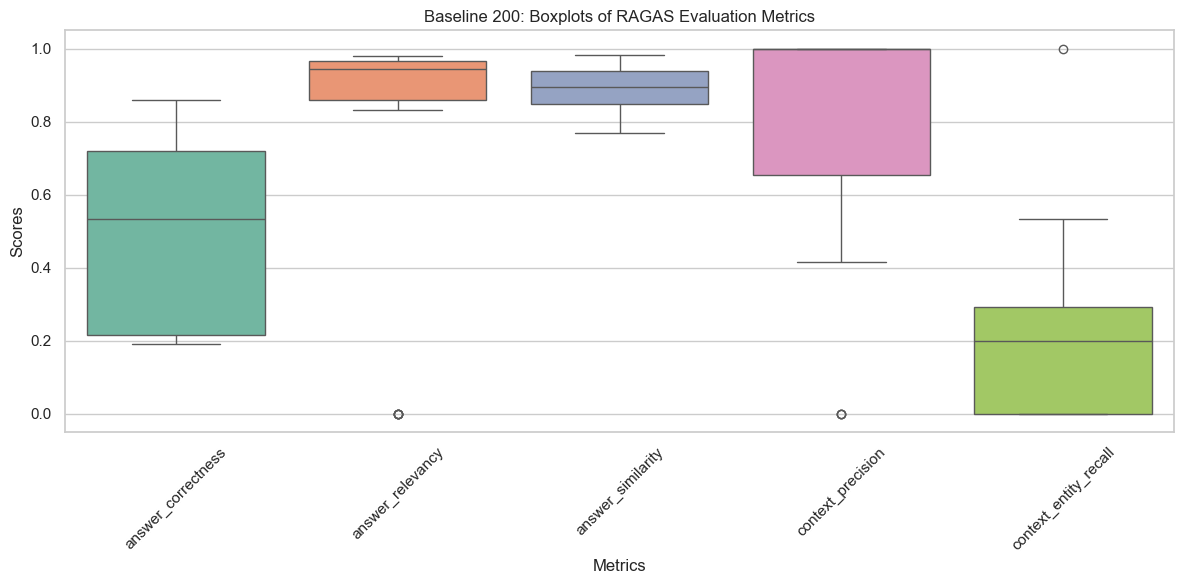

/Users/dmnk/PycharmProjects/npr-rag/src/evaluation.py:319: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=means.index, y=means, palette="Set2")


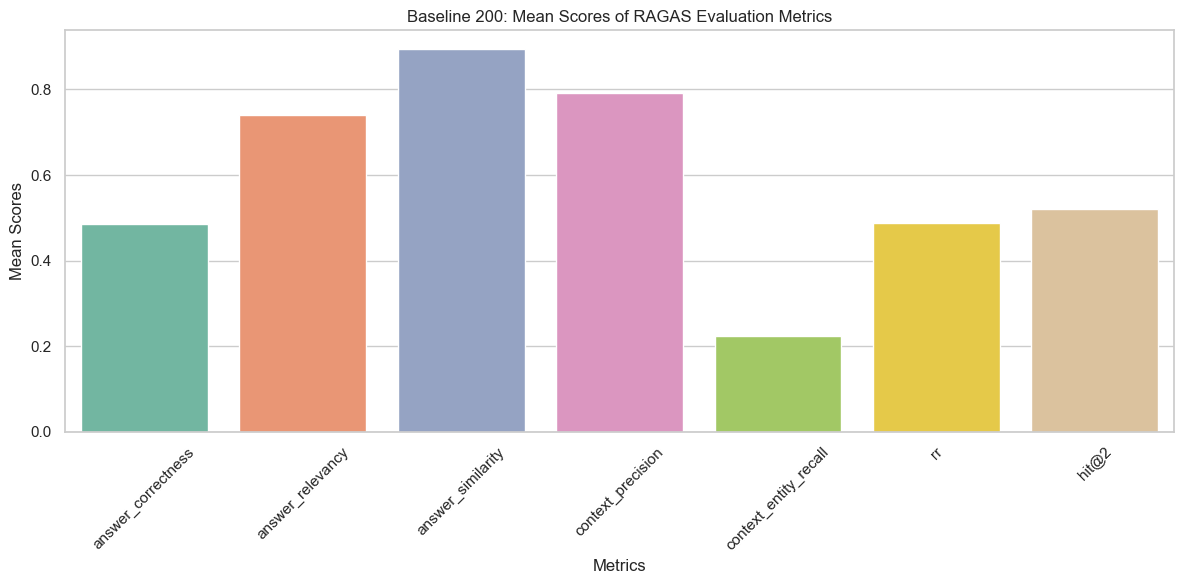

In [82]:
base_200_evaluator = Evaluator(name="Baseline 200",
                               cache_results=USE_CACHE,
                               rag_chain=base_200_rag,
                               llm_model=azure_model,
                               embeddings=bge_embeddings)

base_200_evaluator.evaluate(df_eval)
base_200_evaluator.plot_summary()

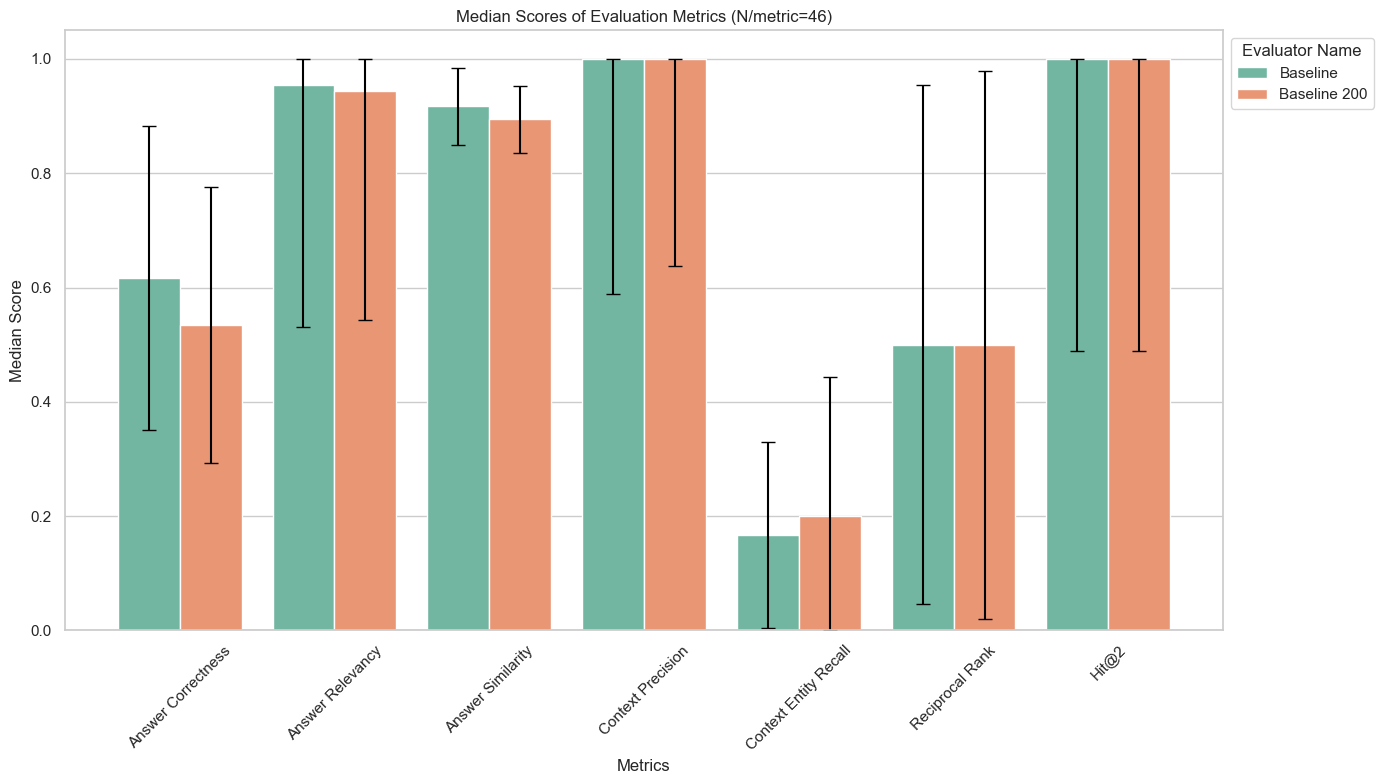

In [83]:
experiment_1_combination = combine_evaluator_results([base_evaluator, base_200_evaluator])
plot_evaluation_comparative_results(experiment_1_combination, use_median=True)

With the changes in chunking we can see a major improvement for the **Answer Relevancy** metric. The new chunking strategy of chunking shorter sequences clearly improved the way the Baseline RAG can process important information. A struggle in the inconsistency of the relevancy seemingly was that there was too much noise around the chunks in the Baseline approach.

An expected tradeoff therefore is that we get a little more spread in regards to the **Context Precision**. The increased spread might be an effect of the retriever falsely gathering chunks that contain similar wording but not the correct semantic meaning. And with that observation we can also expect the Reciprocal Rank and Hit@2 **not to improve** greatly since we add more options for the retriever to gather wrong while reducing noise within the chunks.

In [84]:
base_200_evaluator.get_summary()

,mean,std
answer_correctness,0.486069,0.241412
answer_relevancy,0.741348,0.400983
answer_similarity,0.893514,0.058844
context_precision,0.792271,0.362165
context_entity_recall,0.223913,0.243596
rr,0.489130,0.479573
hit@2,0.521739,0.510754


In [85]:
ask_handpicked_questions(base_200_rag)

Question: Why does melting ice contribute to global warming?
Answer: Melting ice contributes to global warming because it causes freshwater to be released from long-term storage in continental ice sheets and ocean thermal expansion, both of which contribute significantly to sea level rise and global warming. Additionally, warming promotes the net emissions of methane and nitrous oxide in permafrost wetlands, which contributes to global warming.


Question: In 2021, what were the top 3 states in the US in terms of total solar power generating capacity?
Answer: The context does not provide information on the top 3 states in the US in terms of total solar power generating capacity in 2021.


Question: What is the EU’s Green Deal Industrial Plan?
Answer: The EU's Green Deal Industrial Plan is a strategy aimed at making its net zero industry more competitive and accelerating its transition to net zero by boosting investment and economic resilience, easing state aid rules, and facilitating o

The plausibility check shows the measured improvement: The first question of "Why does melting ice contribute to global warming?" now hits a relevant context and the LLM answers based on its information. The previous plausiblity check for the baseline system showed that the LLM did not have relevant context with which it could answer this question.

The second and third question shows no difference; the LLM still answers the questions and has relevant context.

### Conclusion
Overall the hypotheses stated at the beginning of this experiment seem to align with the results we could gather during evaluation. The slightly "worse" Context Precision is a tradeoff that didn't show a drastically negative impact on the system, therefore we can say that the shorter chunks do have a positive impact.

# Experiment 2: Using a Multi-Query Retrieval Strategy

At the heart of the RAG is the retriever, which is responsible for finding the most relevant documents for a given question. The baseline RAG uses the vector retriever to find the most relevant document, using **cosine-similarity**. 

We will now experiment with a **multi-query retrieval strategy**. The idea is to use multiple queries to retrieve a multitude of documents and take a unique union of the results. This way we can increase the diversity of the documents and potentially improve the quality of the generated answer. 

![image.png](./notebooks/images/multiqueryretrieval.png)

For this we will use the `MultiQueryRetriever` from langchain.

In [86]:
from langchain.retrievers import MultiQueryRetriever

mqr_retriever = MultiQueryRetriever.from_llm(
    retriever=base_retriever, llm=azure_model
)

To implement this new strategy we need to update the LLM with the new instruction of generating `5` additional different versions of the users given question. The instruction also states the goal of why this approach should be useful for chunk retrieval.

In [87]:
template = """You are an AI language model assistant. Your task is to generate five 
different versions of the given user question to retrieve relevant documents from a vector 
database. By generating multiple perspectives on the user question, your goal is to help
the user overcome some of the limitations of the distance-based similarity search. 
Provide these alternative questions separated by newlines. Original question: {question}"""

prompt_perspectives = ChatPromptTemplate.from_template(template)

generate_queries = (
        prompt_perspectives
        | azure_model
        | StrOutputParser()
        | (lambda x: x.split("\n"))
)

In [88]:
from langchain.load import dumps, loads

def get_unique_union(union_docs: list[list]):
    """ Unique union of retrieved docs """
    flattened_docs = [dumps(doc) for sublist in union_docs for doc in sublist]
    unique_docs = list(set(flattened_docs))
    return [loads(doc) for doc in unique_docs]

mqr_retrieval_chain = (
        generate_queries
        | mqr_retriever.map()
        | get_unique_union
)

In [89]:
mqr_rag = RunnableParallel(
    {
        "context": mqr_retrieval_chain,
        "question": RunnablePassthrough()
    }
).assign(answer=base_rag_chain)

In [90]:
mqr_rag.invoke("Is the company aiming to reduce gas flaring?")

{'context': [Document(page_content='emissions as does incomplete combustion during the flaring process while flaring converts methane to CO2 More broadly climate change  practically an afterthought during the 2016 presidential campaign  has taken on a more prominent role in political discourse as seen during the debates between Biden and President Trump And while natural gas is the cleanest fossil fuel it increasingly has been under the microscope as its share of the energy mix grows  The world has changed a lot in four years  Erin Blanton senior research scholar at Columbia University s Center on Global Energy Policy told NGI  I think the industry is starting to really wake up to the fact that they have to deal with this black eye which is methaneif they want to survive  The good news she said is that there are numerous policy options to reduce emissions in ways that are technically and economically feasible for the industry One example she cited is the EPA s 2016 Oil and Natural Gas 

### Results

Loaded cached results from cache/Multi-Query Retrieval_16844371965479781967.pkl


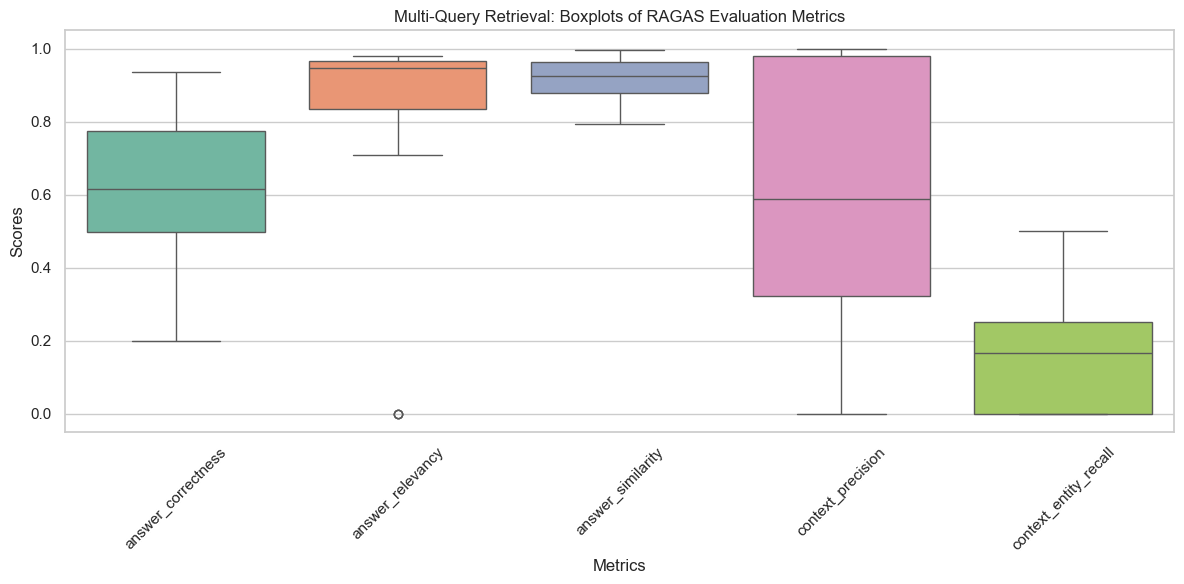

/Users/dmnk/PycharmProjects/npr-rag/src/evaluation.py:319: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=means.index, y=means, palette="Set2")


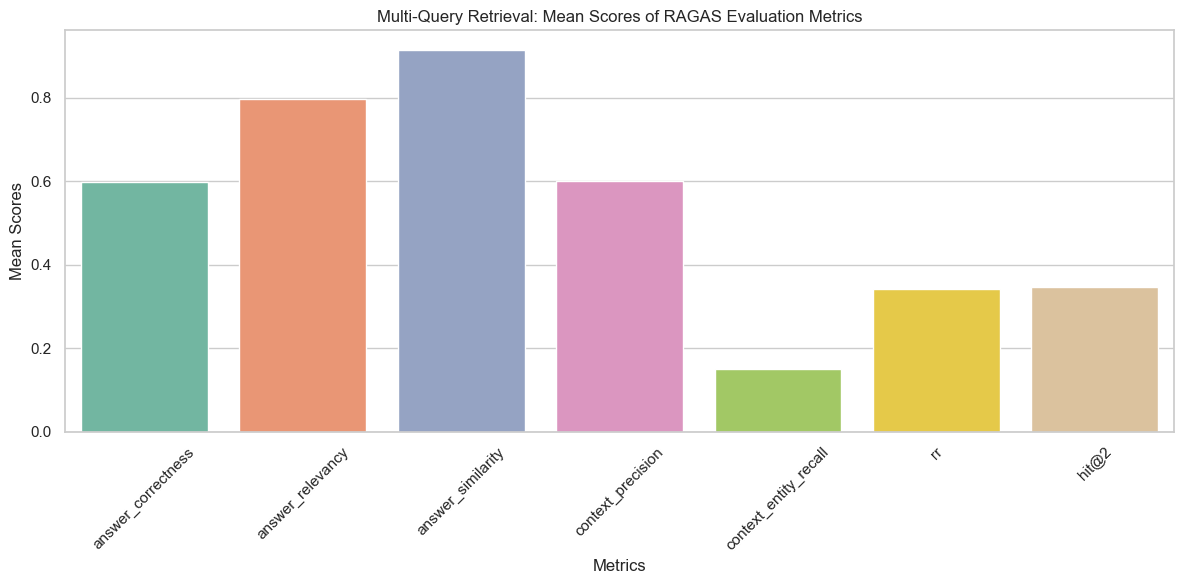

In [91]:
mqr_evaluator = Evaluator(name="Multi-Query Retrieval",
                          cache_results=USE_CACHE,
                          rag_chain=mqr_rag,
                          llm_model=azure_model,
                          embeddings=bge_embeddings)

mqr_evaluator.evaluate(df_eval)
mqr_evaluator.plot_summary()

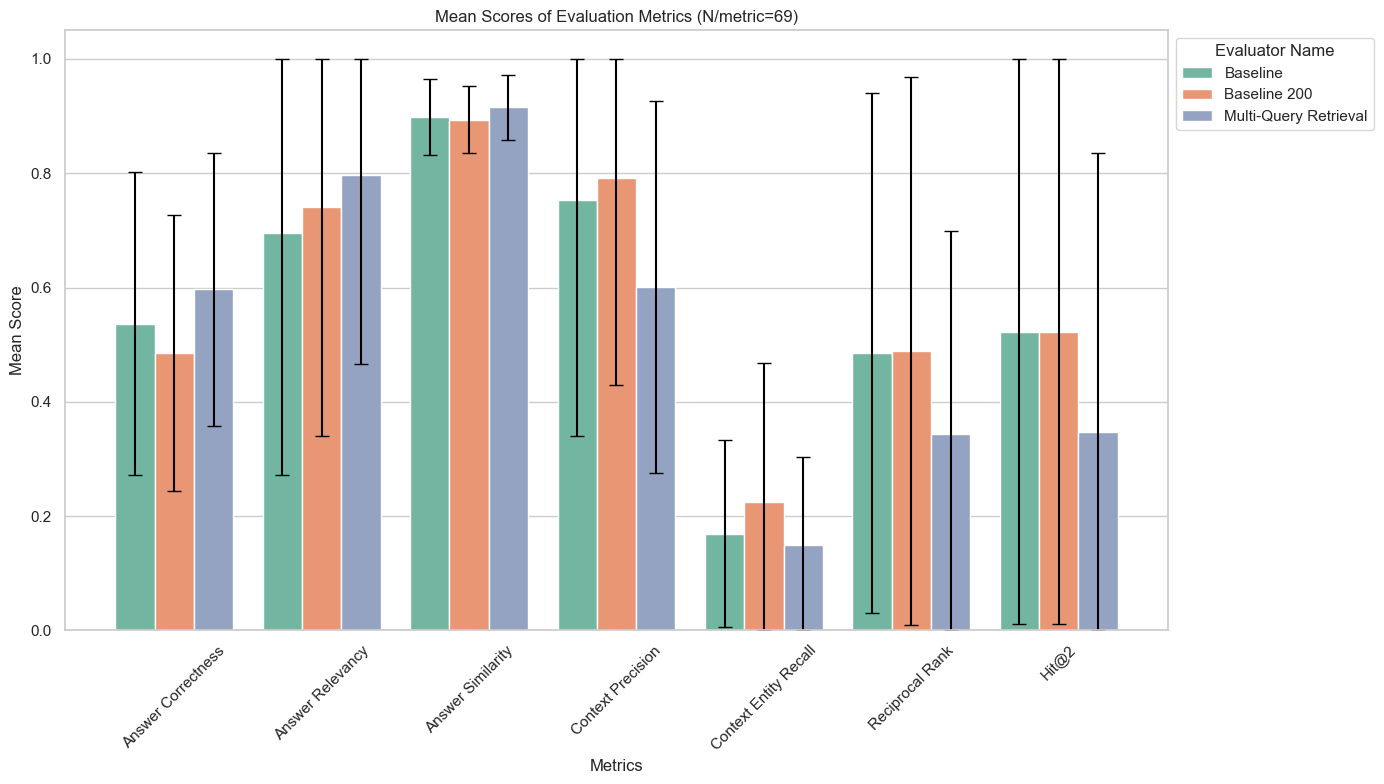

In [92]:
experiment_2_combination = combine_evaluator_results([base_evaluator, base_200_evaluator, mqr_evaluator])
plot_evaluation_comparative_results(experiment_2_combination, use_median=False)

This experiment shows a new improvement in the **Answer Correctness** metric. This metric's distribution had a vast spread in the previous experiments and generally didn't reach scores of 80% and higher. The improvement of the Multi-Query Retrieval squished this metric's distribution towards improved scores. In contrast to this improvement the **Context Precision** gained a large amount of spread which makes sense given that we retrieve more chunks with more questions.

The ranking metrics `rr` and `hit@2` also yield a lower score which is an expected observation with the large amount of documents that we now retrieve. It could also mean that we are generating too many questions but don't have enough documents that can answer these questions - We therefore reintroduce more noise in the retrieval.

In [93]:
mqr_evaluator.get_summary()

,mean,std
answer_correctness,0.597373,0.238922
answer_relevancy,0.797281,0.331404
answer_similarity,0.915494,0.056797
context_precision,0.600861,0.325639
context_entity_recall,0.149741,0.153805
rr,0.343254,0.356178
hit@2,0.347826,0.486985


In [94]:
ask_handpicked_questions(mqr_rag)

Question: Why does melting ice contribute to global warming?
Answer: Melting ice contributes to global warming because it reduces the amount of white ice that reflects the sun's rays, causing a dark sea to absorb over ten times as much solar energy, which contributes to global warming. Additionally, melting ice can lead to the release of greenhouse gases, such as carbon dioxide and methane, that are trapped in permafrost or ocean floor reservoirs. This further exacerbates the effects of global warming.


Question: In 2021, what were the top 3 states in the US in terms of total solar power generating capacity?
Answer: The top 3 states for new solar capacity additions in 2021 were California, Texas, and Florida.


Question: What is the EU’s Green Deal Industrial Plan?
Answer: The EU's Green Deal Industrial Plan is a strategy aimed at boosting investment and economic resilience in the bloc to tackle the challenges of the green transition, with a focus on making its net-zero industry more 

The plausibility check shows that the LLM gained more context and detailed information which seemed to result in the Azure model generating more insights, especially for question 1 and 3. Question 2 answered the same as in the first experiment with the Baseline system.

### Conclusion
We can see clear improvement in the realm of answer correctness though we also seem to lose context precision. In a real world application it would have definitely also made sense to look at how this Multi-Query Retrieval behaves with shorter chunk sizes (combining Experiment 1 and 2). The five additional questions resulted in much more retrieved documents with potentially adds too much noise for the LLM to extract important information from.

# Experiment 3: Using a Step Back Strategy
The Step Back Strategy was first proposed by the Google DeepMind Paper "[TAKE A STEP BACK: EVOKING REASONING VIA ABSTRACTION IN LARGE LANGUAGE MODELS](https://arxiv.org/pdf/2310.06117)". The paper presents a novel way to prompt LLMs with a new 2-step approach:
1. **Abstraction Step**: The first step is to prompt the LLM to "step back" and extract the key principles, concepts or patterns from the given details, rather than focusing on the specifics. For example, for a physics question, the step-back question could be "What are the relevant physics principles at play here?".
2. **Utilizing Abstracted Knowledge**: The second step is to have the LLM use the abstracted knowledge gained from the step-back question to guide its reasoning and arrive at the final solution. This allows the LLM to focus on the core aspects of the task and avoid getting distracted by irrelevant details.

![image.png](./notebooks/images/stepback.png)

We expect the following benefits in the Step-Back Approach:
- **More concrete reasoning**: By "taking a step back" the LLM will be able to understand the core concepts of the underlying question. The LLM should therefore have "the bigger picture".
- **Contextual relevancy**: Stepping back also helps to gain a better overview on a topic which should help the LLM get a better sense of what's relevant and what's not.

In contrast to the benefits the following disadvantage is expected:
- **Loss of detail**: If a question is already very contextually precise taking a step back and adding a less detailed view might not be beneficial but rather introduce unwanted noise.

In [95]:
# Few Shot Examples
from langchain_core.prompts import ChatPromptTemplate, FewShotChatMessagePromptTemplate

examples = [
    {
        "input": "Could the members of The Police perform lawful arrests?",
        "output": "what can the members of The Police do?",
    },
    {
        "input": "Jan Sindel’s was born in what country?",
        "output": "what is Jan Sindel’s personal history?",
    },
]

example_prompt = ChatPromptTemplate.from_messages(
    [
        ("human", "{input}"),
        ("ai", "{output}"),
    ]
)

few_shot_prompt = FewShotChatMessagePromptTemplate(
    example_prompt=example_prompt,
    examples=examples,
)

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are an expert at world knowledge. Your task is to step back and paraphrase a question to a more generic step-back question, which is easier to answer. Here are a few examples:""",
        ),
        few_shot_prompt,
        ("user", "{question}"),
    ]
)
generate_queries_step_back = (prompt | azure_model | StrOutputParser())

In [96]:
from langchain_core.runnables import RunnableLambda

response_prompt_template = """
You are an expert of world knowledge. I am going to ask you a question. Your response should be comprehensive and not contradicted with the following context if they are relevant. Otherwise, ignore them if they are not relevant.

# {context}

# Original Question: {question}
# Answer:
"""
response_prompt = ChatPromptTemplate.from_template(response_prompt_template)


def get_unique_documents(documents):
    """
    Combines and filters documents from 'normal_context' and 'step_back_context' to ensure uniqueness.

    This function merges a list of documents, eliminating any duplicates based on the 'page_content' attribute.
    It assumes that each document in the lists is an object with a 'page_content' attribute that contains the unique content of the document.

    Parameters:
    - documents (list): A list of Langchain document objects.
      Each key corresponds to a list of document objects with a 'page_content' attribute.

    Returns:
    - list: A list of unique document objects based on their 'page_content'.
    """
    seen_content = set()
    combined_docs = []
    for doc in documents:
        if doc.page_content not in seen_content:
            combined_docs.append(doc)
            seen_content.add(doc.page_content)
    return combined_docs


step_back_retrieval_chain = (
    {
        "normal_context": RunnableLambda(lambda x: x) | base_retriever,
        "step_back_context": generate_queries_step_back | base_retriever,
    }
)

step_back_answer_chain = (
        response_prompt
        | azure_model
        | StrOutputParser()
)
step_back_rag = RunnableParallel(
    {
        "context": step_back_retrieval_chain | RunnableLambda(
            lambda x: get_unique_documents(x["normal_context"] + x["step_back_context"])),
        "question": RunnablePassthrough()
    }
).assign(answer=step_back_answer_chain)

In [97]:
step_back_rag.invoke("What is the company's goal in reducing gas flaring?")

{'context': [Document(page_content='Qatar Petroleum  QP has launched a new sustainability strategy aiming to reduce the emissions intensity of its LNG facilities by 25 The company also aims to reduce emissions from its upstream facilities by at least 15 and cut flaring intensity in the upstream by more than 75 The Qatari NOC set 2013 as the baseline It intends to achieve the targets by 2030 QP is targeting an end to routine flaring by 2030 and limiting fugitive methane emissions It will accomplish this by setting a methane intensity target of 02 across all facilities by 2025 The company has spent  900 million between 2012 and 2018 on reducing flaring Another  170mn has been committed for investment from 2018 to 2021 QP has committed to using carbon capture and storage  CCS facilities to capture more than 7 million tonnes per year In December 2020 QP said it planned to sequester this amount of CO2 by 2027 The strategy is consistent with the Paris Agreement the company has said QP aims t

### Results

Loaded cached results from cache/Step Back_16844371965479781967.pkl


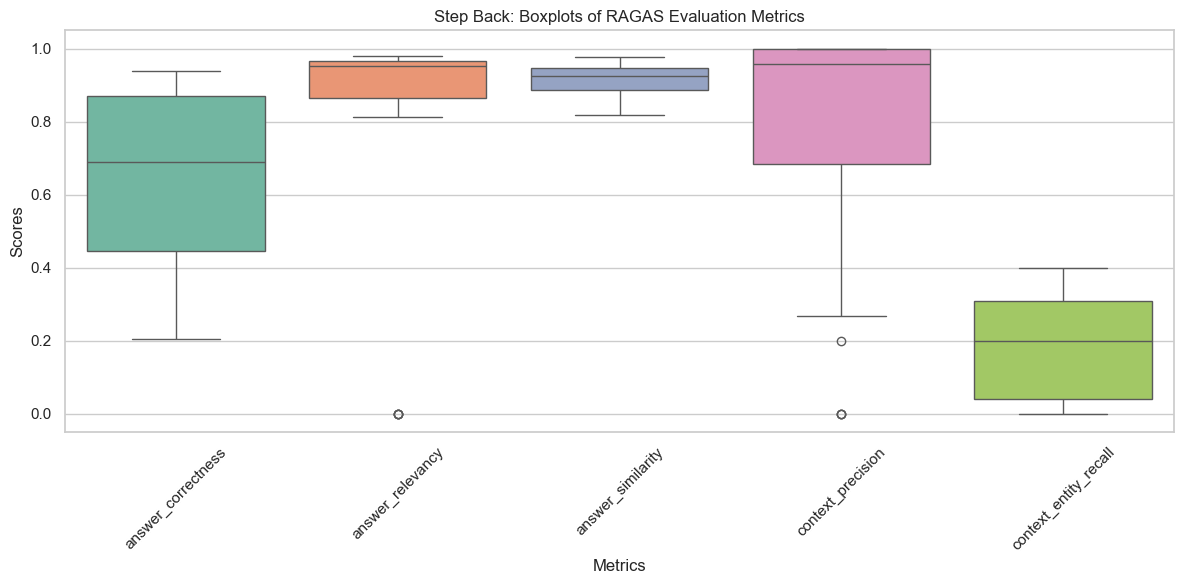

/Users/dmnk/PycharmProjects/npr-rag/src/evaluation.py:319: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=means.index, y=means, palette="Set2")


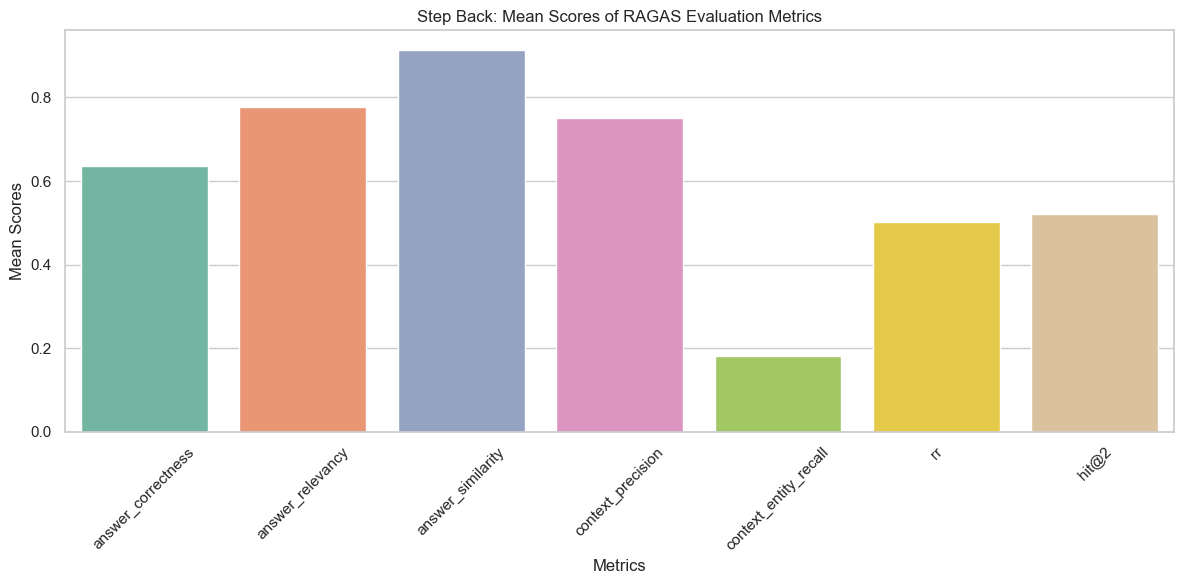

In [98]:
step_back_evaluator = Evaluator(name="Step Back",
                                cache_results=USE_CACHE,
                                rag_chain=step_back_rag,
                                llm_model=azure_model,
                                embeddings=bge_embeddings)

step_back_evaluator.evaluate(df_eval)
step_back_evaluator.plot_summary()

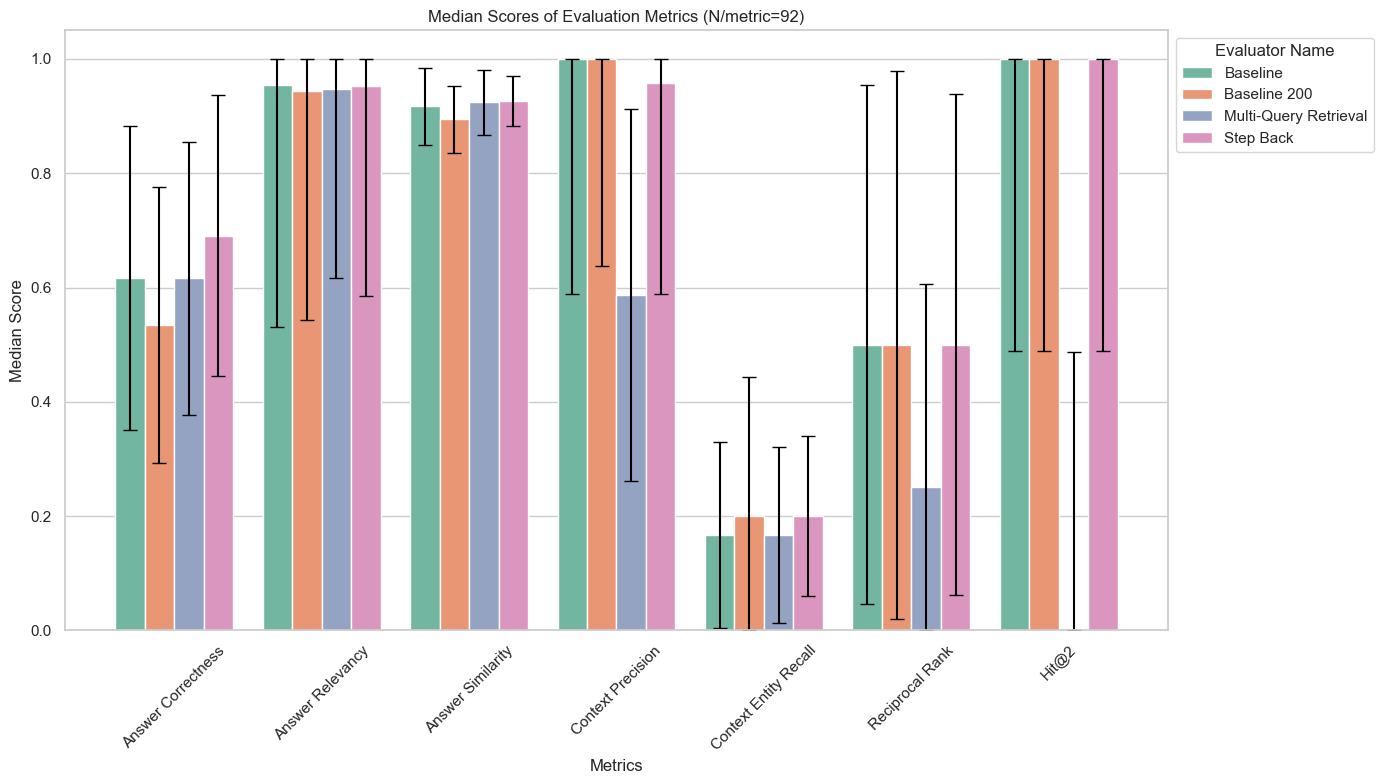

In [99]:
experiment_3_combination = combine_evaluator_results([base_evaluator, base_200_evaluator, mqr_evaluator, step_back_evaluator])
plot_evaluation_comparative_results(experiment_3_combination, use_median=True)

An interesting observation is that the **Answer Correctness** seems to have stayed the same in its distribution shape but shifted up towards a higher score. The decrease in the median score of "Answer Relevancy" might indicate that while the answers are correct, they might not be as closely aligned to the specifics of the query as before. This shift could be due to the abstraction step, which focuses on general principles rather than the finer details of the question, potentially leading to answers that are correct in a broader sense but less tailored to the specific query context.

In [100]:
step_back_evaluator.get_summary()

,mean,std
answer_correctness,0.636261,0.245892
answer_relevancy,0.776575,0.366800
answer_similarity,0.914379,0.043691
context_precision,0.750880,0.370373
context_entity_recall,0.180952,0.140376
rr,0.502899,0.438767
hit@2,0.521739,0.510754


In [ ]:
ask_handpicked_questions(step_back_rag)

When taking a closer look at the plausibility check the handpicked questions show a new observation for all 3 questions: The answers are much longer and go in thorough detail on the concepts in the answer.

### Conclusion
To conclude this Experiment, the Step Back Strategy appears to enhance the precision of the retrieval process by emphasizing core concepts and principles over specific details. However, this focus leads to slightly less tailored detailed answers, as seen in the reduced relevancy and similarity scores. These observations underscore the trade-off between abstract reasoning and the granularity of response specificity, which might need further tuning to optimize both the relevance and correctness of the answers.

The experiment showed clear effects on the plausibility check as the LLM really elaborated on the superficial concepts.

# Experiment 4: HyDE approach

The HyDE approach is a novel method that combines human and AI expertise to generate high-quality answers. Originally proposed by Gao et al. (2022) in the paper ["Precise Zero-Shot Dense Retrieval without Relevance Label"](https://arxiv.org/abs/2212.10496), the HyDE pipeline leverages the innovative concept of Hypothetical Document Embeddings (HyDE).

In the HyDE approach, an instruction-following language model, such as our Azure Model using the right prompting, is used to generate a hypothetical document in response to a query. This document is designed to capture the essential relevance patterns from the input question potentially containing inaccuracies or hypothetical details. Following this, the document is used to retrieve relevant documents from the vector store, which are then passed to the LLM model for answer generation.

This two-step process allows the HyDE model to ground the generated hypothetical content in actual data, effectively filtering out incorrect or irrelevant details through the embedding's bottleneck.

![image.png](./notebooks/images/hyde.png)

The graphic might falsely suggest that the hypothetical document will be embedded but it is merely used to query during the retrieval in inference-time. But the illustration shows the hypothesis that an LLM-generated hypothetical document may already be closer to the relevant chunks in the embedding space as it is much richer with relevant information that the original input question might not capture.

In [ ]:
from langchain_core.runnables import RunnablePassthrough
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

system = """You are an expert about the Clean Technology Sector.
            Answer the user question as best you can. Answer as though you were writing a tutorial that addressed the user question."""

hyde_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

gen_hypothetical_doc = (
        hyde_prompt
        | azure_model
        | StrOutputParser()
)

In [ ]:
hyde_retrieval_chain = (gen_hypothetical_doc
                        | base_retriever
                        )

hyde_rag = RunnableParallel(
    {
        "question": RunnablePassthrough(),
        "context": hyde_retrieval_chain
    }
).assign(answer=base_rag_chain)

hyde_rag.invoke("What is the company's goal in reducing gas flaring?")

### Results

In [ ]:
hyde_evaluator = Evaluator(name="HyDE",
                           cache_results=USE_CACHE,
                           rag_chain=hyde_rag,
                           llm_model=azure_model,
                           embeddings=bge_embeddings)

hyde_evaluator.evaluate(df_eval)
hyde_evaluator.plot_summary()

In [ ]:
experiment_4_combination = combine_evaluator_results([base_evaluator, base_200_evaluator, mqr_evaluator, step_back_evaluator, hyde_evaluator])
plot_evaluation_comparative_results(experiment_4_combination, use_median=True)

The results of this 4th experiment show very similar metrics to the baseline RAG which is interesting as the HyDE approach actually should show a more meaningful ability in the retrieval.

If we just focus on comparing the HyDE approach with the Baseline RAG we can see a positive shift in the **Answer Correctness** metric which is expected as we improve the retrieval strategy by giving the retrieval query a more detailed chunk to query with.

Compared with the other approaches (Experiment 1 to 3) this approach seems to not improve the RAG system in a more meaningful way on multiple metrics.

In [ ]:
hyde_evaluator.get_summary()

In [ ]:
ask_handpicked_questions(hyde_rag)

The plausibility check in contrast to the Baseline RAG that the first question's context can be retrieved and therefore be answered. The second question seems to stay the same while the third question shows a concise but exact answer which seems plausible.

### Conclusion
The HyDE experiment showed a slight improvement in **Answer Correctness** compared to the metrics in the Baseline RAG. Compared to the other approaches though, this approach rather falls short.

# Experiment 5: Contextual Compression
Contextual Compression addresses the challenge in information retrieval of optimizing how relevant information is extracted from large datasets or documents. The relevant information for some specific query may well be buried in a larger chunk with surrounding text that isn't really relevant to the input question. We hypothesize that this fact will lead to a poorer performance of of the RAG system as the LLM will have much more information on its hand but will have a hard time attending the relevant part of the retrieved document because it contains a lot of noise. 

Contextual Compression however attempts to solve this issue by first compressing the retrieved documents to their "crucial parts" that actually contain the context-relevant information before using them to generate an answer. The `ContextualCompressionRetriever` will not only compress the contents of each document but also remove or "compress" entire documents that may show to not be valuable in their context.

In [ ]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor

chain_extractor_compressor = LLMChainExtractor.from_llm(azure_model)
compression_retriever = ContextualCompressionRetriever(
    base_compressor=chain_extractor_compressor, base_retriever=base_retriever
)

base_rag_chain_compression = (
        RunnablePassthrough.assign(context=(lambda x: format_docs(x["context"])))
        | ChatPromptTemplate.from_template(base_rag_prompt)
        | azure_model
        | StrOutputParser()
)

base_rag_compression = RunnableParallel(
    {
        "context": compression_retriever,
        "question": RunnablePassthrough()
    }
).assign(answer=base_rag_chain_compression)

base_rag_compression.invoke("Is the company aiming to reduce gas flaring?")

### Results

In [ ]:
base_compression_evaluator = Evaluator(name="Contextual Compression",
                                       cache_results=USE_CACHE,
                                       rag_chain=base_rag_compression,
                                       llm_model=azure_model,
                                       embeddings=bge_embeddings)

base_compression_evaluator.evaluate(df_eval)
base_compression_evaluator.plot_summary()

In [ ]:
experiment_5_combination = combine_evaluator_results([base_evaluator, base_200_evaluator, mqr_evaluator, step_back_evaluator, hyde_evaluator, base_compression_evaluator])
plot_evaluation_comparative_results(experiment_5_combination, use_median=True)

The most drastic observation that instantly arises is the large interquartile range of the **Answer Relevancy**. It suggests that the contextual compression might have been too harsh in the compression of information. Compared to the Baseline RAG system it doesn't show a change in any other metric.

In [ ]:
base_compression_evaluator.get_summary()

In [ ]:
ask_handpicked_questions(base_rag_compression)

The first question gets answered very generally, perhaps without the inclusion of chunked information. The second question however seems to not have any context which was used by the LLM to answer the question. It rather seems made up by the LLMs knowledge. The third question is however again more regular and gets answered with much more detail and is therefore very plausible to be correct.

### Conclusion
The extreme increase in the **Answer Relevancy**'s spread can possibly already be seen in the plausibility check. The check showed that for some of the questions this approach still found relevant chunks and answered rich in detail while in other cases it struggled with detail and even with finding relevant context. It can be assumed that the compression was just too harsh and got rid of too much important granular detail.

# Overall Comparison

In this section, we will compare the performance of the different pipelines based on the evaluation metrics. The comparison will provide insights into the effectiveness of each pipeline in generating accurate and relevant answers to the questions. The evaluation metrics include both LLM-based metrics and non-LLM-based metrics to provide a comprehensive assessment of the pipelines' performance
.

In [ ]:
evaluators = [base_evaluator,
              base_200_evaluator,
              mqr_evaluator,
              step_back_evaluator,
              hyde_evaluator,
              base_compression_evaluator]

combined_results = combine_evaluator_results(evaluators)

## Comparative Evaluation Results

In [ ]:

plot_evaluation_comparative_results(combined_results, use_median=False, err_bars=False)

- **HyDE** demonstrates relative strong performance across correctness, relevancy, and precision metrics, highlighting its capability to leverage synthetic documents effectively for high-quality information retrieval.

- **Baseline 200 (Shorter Chunking)** shows consistently high performance, especially in ranking metrics and answer similarity,  robust retrieval and matching capabilities.

- The **Step Back** strategy shines in its stronger capabilities in the Answer Correctness and Context Precision which can be achieved with the larger overview on subjects.

- The **Multi-Query Retrieval** achieves the best overall scores in Answer Relevancy and Answer Similarity but struggles within the ranking specific metrics due to its great variance in different retrieved document chunks.

- The default **Baseline RAG** shows to be a good middle ground amidst all the explored alterations.

In [ ]:
plot_evaluation_comparative_results(combined_results, use_median=True, err_bars=False)

The median in contrast to the mean is stable among the experimented approaches in regards to Answer Relevancy, Answer Similarity and Context Entity Recall. 

Within the Answer Correctness the **HyDE** approach seems to differentiate itself the most from the other explored methods with its negative skew in the distribution.

The **Multi-Query Retrieval** stands out particularly in the Context Precision, Reciprocal Rank and Hit@2 where it scores significantly lower than the other explored methods.

In [ ]:
def plot_metric_boxplots(data):
    sns.set(style="whitegrid")

    metrics = [
        'Answer Correctness', 'Answer Relevancy', 'Answer Similarity',
        'Context Precision', 'Context Entity Recall'
    ]

    data_filtered = data[metrics + ['Evaluator']]
    data_long = pd.melt(data_filtered, id_vars=['Evaluator'], value_vars=metrics,
                        var_name='Metric', value_name='Value')

    plt.figure(figsize=(12, 8))
    sns.boxplot(
        x='Metric',
        y='Value',
        hue='Evaluator',
        data=data_long,
        palette='Set2'
    )

    plt.title('Distribution of Evaluation Metrics Across Evaluators')
    plt.xlabel('Metric')
    plt.ylabel('Values')
    plt.xticks(rotation=45)
    plt.legend(title='Evaluator', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()


plot_metric_boxplots(combined_results)

When looking at the distributions of all methods pretty much all approaches show a wide spread in the Answer Correctness, Context Precision and Context Entity Recall. Within this observation the **Step Back** approach seems to be the most stable with the least spread in all boxplots.

The **Contextual Compression** and **Baseline RAG** approach seem to struggle the most with consistency as their metrics have a large spread in almost all metrics but the Answer Similarity.

## Aggregated Correctness vs. Precision

By plotting these metrics against each other, stakeholders can quickly discern whether there is a correlation between the precision of the context provided to the generator and the accuracy of the answers generated. For example, a positive correlation would suggest that improving context precision could lead to more accurate answers.

Each point on the scatter plot represents an evaluator, with the x-axis showing the average correctness of the answers generated and the y-axis showing the average precision of the context provided to the generator. The color of the points corresponds to the evaluator, allowing for easy identification of each evaluator's performance. The point values is the mean of the respective metric across all questions in the evaluation set.

In [ ]:
def plot_aggregated_correctness_vs_precision(data):
    sns.set(style="whitegrid")
    aggregated_data = data.groupby('Evaluator').agg({
        'Answer Correctness': 'mean',
        'Context Precision': 'mean'
    }).reset_index()

    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x='Answer Correctness',
        y='Context Precision',
        hue='Evaluator',
        data=aggregated_data,
        palette='Set2',
        s=100
    )

    plt.title('Mean Correctness vs. Precision across Evaluators')
    plt.xlabel('Average Answer Correctness (Accuracy)')
    plt.ylabel('Average Context Precision (Relevance)')
    plt.legend(title='Evaluator', bbox_to_anchor=(1.05, 1), loc=2)
    plt.tight_layout()
    plt.ylim(0, 1)
    plt.xlim(0, 1)
    plt.show()


plot_aggregated_correctness_vs_precision(combined_results)

There doesn't seem to be any particular clear correlation. The **Step Back** shows to be performing the best when it comes to the combination of the Accuracy and Relevance.

When looking at all the other approaches one could imagine the both metrics to be negatively correlated as the ones with high Relevance show lower Accuracy and vice versa. Though it's hard to say if this holds up - The **Step Back** approach for example doesn't follow this pattern so it's fair to say that it depends very much on what an approach actually implements and improves on.

## Aggregated Correctness vs. Reciprocal Rank

In [ ]:
def plot_aggregated_correctness_vs_rr(data):
    sns.set(style="whitegrid")
    aggregated_data = data.groupby('Evaluator').agg({
        'Answer Correctness': 'mean',
        'Reciprocal Rank': 'mean'
    }).reset_index()

    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x='Answer Correctness',
        y='Reciprocal Rank',
        hue='Evaluator',
        data=aggregated_data,
        palette='Set2',
        s=100
    )

    plt.title('Mean Correctness vs. Reciprocal Rank across Evaluators')
    plt.xlabel('Mean Answer Correctness')
    plt.ylabel('Mean Reciprocal Rank')
    plt.legend(title='Evaluator', bbox_to_anchor=(1.05, 1), loc=2)
    plt.tight_layout()
    plt.ylim(0, 1)
    plt.xlim(0, 1)
    plt.show()


plot_aggregated_correctness_vs_rr(combined_results)

The same observation can be done here, the **Step Back** approach reaches the highest MRR and Mean Answer Correctness. The other experiments, on the other hand, fall out lower.

## Confidence vs. Answer Correctness

In [ ]:
def plot_confidence_vs_correctness(data):
    sns.set(style="whitegrid")

    metrics = [
        'Answer Correctness', 'Answer Relevancy', 'Answer Similarity',
        'Context Precision', 'Context Entity Recall', 'Reciprocal Rank', 'Hit@2'
    ]

    stats = data.groupby('Evaluator')[metrics].agg(['mean', 'std'])

    stats['Avg STD'] = stats[[(m, 'std') for m in metrics]].mean(axis=1)
    max_std = stats['Avg STD'].max()
    stats['System Confidence'] = max_std + 1 - stats['Avg STD']

    stats.columns = [' '.join(col).strip() for col in stats.columns.values]
    stats.reset_index(inplace=True)

    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x='System Confidence',
        y='Answer Correctness mean',
        hue='Evaluator',
        data=stats,
        s=100,
        palette='Set2',
        legend='full'
    )

    plt.title('System Confidence vs. Answer Correctness')
    plt.xlabel('System Confidence (Inferred from Avg. STD of Metrics)')
    plt.ylabel('Answer Correctness (Mean)')
    plt.ylim(0, 1)
    plt.legend(title='Evaluator', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


plot_confidence_vs_correctness(combined_results)